In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy.stats as stats

from sklearn.model_selection import (cross_val_predict, cross_val_score, train_test_split, GridSearchCV)
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

In [2]:
qdb = pd.read_csv('quake_db_1965-2016.csv')
qdb.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status,Place
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,Unknown
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,"Ngidihopitonu, ID"
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic,"Pangai, TO"
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic,Unknown
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic,"Dapdap, PH"


In [3]:
qdb.columns

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Depth', 'Depth Error',
       'Depth Seismic Stations', 'Magnitude', 'Magnitude Type',
       'Magnitude Error', 'Magnitude Seismic Stations', 'Azimuthal Gap',
       'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'ID',
       'Source', 'Location Source', 'Magnitude Source', 'Status', 'Place'],
      dtype='object')

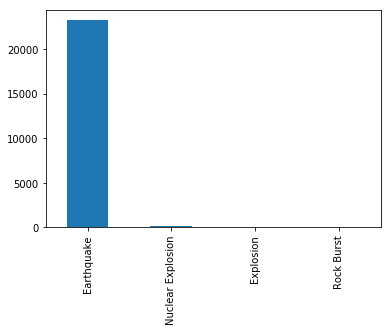

In [4]:
qdb['Type'].value_counts().plot(kind='bar')

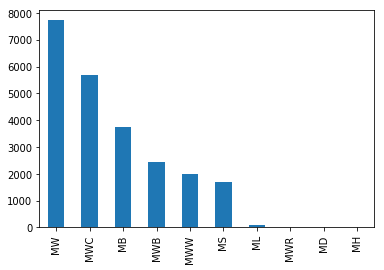

In [5]:
qdb['Magnitude Type'].value_counts().plot(kind='bar')

In [6]:
japan = qdb[qdb['Place'].str.contains('JP')]
japan.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status,Place
55,02/16/1965,12:24:10,38.908,142.095,Earthquake,53.5,NaN,NaN,5.7,MW,...,NaN,NaN,NaN,NaN,ISCGEM860246,ISCGEM,ISCGEM,ISCGEM,Automatic,"Ofunato, JP"
89,03/16/1965,16:46:17,40.697,143.032,Earthquake,32.1,NaN,NaN,6.4,MW,...,NaN,NaN,NaN,NaN,ISCGEM858655,ISCGEM,ISCGEM,ISCGEM,Automatic,"Kuji, JP"
101,03/29/1965,10:47:38,40.687,142.915,Earthquake,30.0,NaN,NaN,6.4,MW,...,NaN,NaN,NaN,NaN,ISCGEM858966,ISCGEM,ISCGEM,ISCGEM,Automatic,"Kuji, JP"
111,04/06/1965,05:31:59,36.083,139.968,Earthquake,50.0,NaN,NaN,5.7,MW,...,NaN,NaN,NaN,NaN,ISCGEM857506,ISCGEM,ISCGEM,ISCGEM,Automatic,"Ishige, JP"
122,04/15/1965,05:09:50,25.080,122.897,Earthquake,165.0,NaN,NaN,5.6,MW,...,NaN,NaN,NaN,NaN,ISCGEM857769,ISCGEM,ISCGEM,ISCGEM,Automatic,"Yonakuni, JP"


In [7]:
japan.shape

(1347, 22)

In [8]:
def nan_helper(y):    
    return np.isnan(y), lambda z: z.nonzero()[0]

In [9]:
def get_interpolation(my_df, nan_series):
    arr_series = np.array(my_df[str(nan_series)])
    nans, x = nan_helper(arr_series)
    arr_series[nans] = np.interp(x(nans), x(~nans), arr_series[~nans])
    return arr_series.round(2)

In [10]:
japan.loc[:, 'Depth Error'] = get_interpolation(japan, 'Depth Error')
japan.loc[:, 'Depth Seismic Stations'] = get_interpolation(japan, 'Depth Seismic Stations')
japan.loc[:, 'Magnitude Error'] = get_interpolation(japan, 'Magnitude Error')
japan.loc[:, 'Magnitude Seismic Stations'] = get_interpolation(japan, 'Magnitude Seismic Stations')
japan.loc[:, 'Azimuthal Gap'] = get_interpolation(japan, 'Azimuthal Gap')
japan.loc[:, 'Horizontal Distance'] = get_interpolation(japan, 'Horizontal Distance')
japan.loc[:, 'Horizontal Error'] = get_interpolation(japan, 'Horizontal Error')
japan.loc[:, 'Root Mean Square'] = get_interpolation(japan, 'Root Mean Square')

In [11]:
def label_integer_encoder(my_df, series_name):
    arr_name = np.array(list(my_df[str(series_name)]))
    label_arr_encoder = LabelEncoder()
    integer_arr_encoded = label_arr_encoder.fit_transform(arr_name)
    return integer_arr_encoded

In [12]:
japan.loc[:, 'Type'] = label_integer_encoder(japan, 'Type')
japan.loc[:, 'Status'] = label_integer_encoder(japan, 'Status')
japan.loc[:, 'Magnitude Type'] = label_integer_encoder(japan, 'Magnitude Type')
japan.loc[:, 'Place'] = label_integer_encoder(japan, 'Place')

In [13]:
japan.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status,Place
55,02/16/1965,12:24:10,38.908,142.095,0,53.5,3.1,412.0,5.7,2,...,112.5,3.36,5.9,1.0,ISCGEM860246,ISCGEM,ISCGEM,ISCGEM,0,133
89,03/16/1965,16:46:17,40.697,143.032,0,32.1,3.1,412.0,6.4,2,...,112.5,3.36,5.9,1.0,ISCGEM858655,ISCGEM,ISCGEM,ISCGEM,0,81
101,03/29/1965,10:47:38,40.687,142.915,0,30.0,3.1,412.0,6.4,2,...,112.5,3.36,5.9,1.0,ISCGEM858966,ISCGEM,ISCGEM,ISCGEM,0,81
111,04/06/1965,05:31:59,36.083,139.968,0,50.0,3.1,412.0,5.7,2,...,112.5,3.36,5.9,1.0,ISCGEM857506,ISCGEM,ISCGEM,ISCGEM,0,42
122,04/15/1965,05:09:50,25.080,122.897,0,165.0,3.1,412.0,5.6,2,...,112.5,3.36,5.9,1.0,ISCGEM857769,ISCGEM,ISCGEM,ISCGEM,0,229


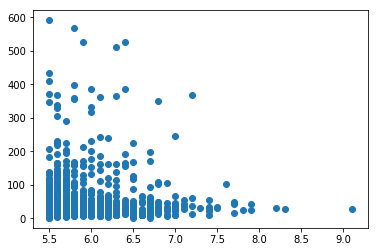

In [14]:
plt.scatter(japan['Magnitude'], japan['Depth'])
plt.show()

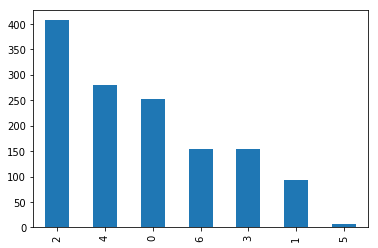

In [15]:
japan['Magnitude Type'].value_counts().plot(kind='bar')

In [16]:
X = japan[['Magnitude', 'Depth', 'Magnitude Error', 'Magnitude Type', 'Depth Error', 'Azimuthal Gap', 
           'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'Place']]
y = japan[['Latitude', 'Longitude']]

In [17]:
X.shape
X.head()

,Magnitude,Depth,Magnitude Error,Magnitude Type,Depth Error,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,Place
55,5.7,53.5,0.04,2,3.1,112.5,3.36,5.9,1.0,133
89,6.4,32.1,0.04,2,3.1,112.5,3.36,5.9,1.0,81
101,6.4,30.0,0.04,2,3.1,112.5,3.36,5.9,1.0,81
111,5.7,50.0,0.04,2,3.1,112.5,3.36,5.9,1.0,42
122,5.6,165.0,0.04,2,3.1,112.5,3.36,5.9,1.0,229


In [18]:
y.shape

(1347, 2)

In [19]:
# X = preprocessing.StandardScaler().fit(X).transform(X)
# X[0:5]

In [20]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1077, 10)
(1077, 2)
(270, 10)
(270, 2)


In [21]:
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
preds = reg.predict(X_test)
accuracy = reg.score(X_test, y_test)
print(accuracy)

0.7642734426670634


In [22]:
parameters = {'n_estimators' : [16, 23, 43, 87, 45, 550, 680]}
gs = GridSearchCV(reg, parameters, cv=10)
grid_fit = gs.fit(X_train, y_train)
best_fit = grid_fit.best_estimator_
print(best_fit)
y_hat = best_fit.predict(X_test)
gs_a = best_fit.score(X_test, y_test)
print(gs_a)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=550,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
0.7947744367157392
